In [32]:
import logging

logging.basicConfig(
    format='%(asctime)s %(levelname)-8s %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [33]:
import data
from sklearn.preprocessing import StandardScaler
from torch.nn import MSELoss
from torch.utils.data import DataLoader
from IPython.core.debugger import set_trace
import importlib
import numpy as np
import pandas as pd
import torch

torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(42)

In [34]:
importlib.reload(data)

response_data = data.ExVivoDrugData.load_data()
merge_data = data.MergeData.load_data()

2019-11-19 11:02:23 INFO     Loading drug response data
2019-11-19 11:02:26 INFO     Drug response data loaded
2019-11-19 11:02:26 INFO     Loading merge data
2019-11-19 11:02:27 INFO     Merge data loaded


In [35]:
overlapping_genes = list(set(response_data.X.columns).intersection(merge_data.data.columns))
merge_data.data = merge_data.data[overlapping_genes]
response_data.X = response_data.X[["patient_id"] + response_data.drug_columns + overlapping_genes]

In [36]:
kfold_split = response_data.kfold_patient_split(5)

2019-11-19 11:02:29 INFO     Splitting drug response data into 5 folds
2019-11-19 11:02:42 INFO     Splitting complete


In [37]:
my_split = kfold_split[1]

In [38]:
max_patients = 0
drug_with_max_patients = None

for drug_col in response_data.drug_columns:
    patients_for_drug = my_split.X_train[my_split.X_train[drug_col] == 1].shape[0]
    if patients_for_drug > max_patients:
        max_patients = patients_for_drug
        drug_with_max_patients = drug_col

In [39]:
import datetime
import time

criterion = MSELoss()
num_epochs = 300
learning_rate = 5e-7
prior_learning_rate = 5e-7

mlp_errors = []
def train(model, num_epochs):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = model(X_batch)
            loss_train = criterion(output, y_batch)
            
            loss_train.backward()
            f1_optimizer.step()
            
        model.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = model(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            mlp_errors.append(loss_test)
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))

In [40]:
from models import MLP
import torch
from torch import optim

my_split = kfold_split[0]

max_drug_indices_train = my_split.X_train[drug_with_max_patients] == 1
max_drug_indices_test = my_split.X_test[drug_with_max_patients] == 1

my_split.X_train = my_split.X_train[max_drug_indices_train]
my_split.X_test = my_split.X_test[max_drug_indices_test]
my_split.y_train = my_split.y_train[max_drug_indices_train]
my_split.y_test = my_split.y_test[max_drug_indices_test]

my_split.X_train.drop(response_data.drug_columns, axis=1, inplace=True)
my_split.X_test.drop(response_data.drug_columns, axis=1, inplace=True)

In [41]:
X_train = my_split.X_train
y_train = my_split.y_train

X_test = my_split.X_test
y_test = my_split.y_test
    
N, D_in, H1, H2, D_out = 32, X_train.shape[1], 512, 256, 1
f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate, weight_decay=5e-3)

In [42]:
feature_scaler = StandardScaler()
outcome_scaler = StandardScaler()

logging.info("Fitting feature scalers")
feature_scaler.fit(X_train[X_train.columns])
outcome_scaler.fit(y_train[y_train.columns])
logging.info("Finished fitting feature scalers")

logging.info("Applying feature scalar")
X_train[X_train.columns] = feature_scaler.transform(X_train[X_train.columns])
X_test[X_test.columns] = feature_scaler.transform(X_test[X_test.columns])

y_train[y_train.columns] = outcome_scaler.transform(y_train[y_train.columns])
y_test[y_test.columns] = outcome_scaler.transform(y_test[y_test.columns])
logging.info("Finished scaling features")

2019-11-19 11:02:47 INFO     Fitting feature scalers
2019-11-19 11:02:47 INFO     Finished fitting feature scalers
2019-11-19 11:02:47 INFO     Applying feature scalar
2019-11-19 11:02:47 INFO     Finished scaling features


In [43]:
# Create random Tensors to hold inputs and outputs
train_dataset = data.ExVivoDrugData(X_train, y_train)
test_dataset = data.ExVivoDrugData(X_test, y_test)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=N,
    shuffle=True,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=X_test.shape[0],
    shuffle=False,
    drop_last=False
)

background_dataset = data.ExVivoDrugData(X_train, y_train)

In [44]:
train(f1, num_epochs)

Beginning model training at 2019-11-19 11:02:47.521815


2019-11-19 11:02:48 INFO     Epoch 0 completed in 0.5332815647125244 secs with test loss 1.1905
2019-11-19 11:02:53 INFO     Epoch 10 completed in 0.5076098442077637 secs with test loss 1.0747
2019-11-19 11:02:58 INFO     Epoch 20 completed in 0.4594695568084717 secs with test loss 1.0063
2019-11-19 11:03:03 INFO     Epoch 30 completed in 0.5368795394897461 secs with test loss 0.9582
2019-11-19 11:03:08 INFO     Epoch 40 completed in 0.5201289653778076 secs with test loss 0.9208
2019-11-19 11:03:14 INFO     Epoch 50 completed in 0.7530248165130615 secs with test loss 0.8902
2019-11-19 11:03:21 INFO     Epoch 60 completed in 0.6446938514709473 secs with test loss 0.8640
2019-11-19 11:03:27 INFO     Epoch 70 completed in 0.7800159454345703 secs with test loss 0.8431
2019-11-19 11:03:34 INFO     Epoch 80 completed in 0.5992145538330078 secs with test loss 0.8258
2019-11-19 11:03:40 INFO     Epoch 90 completed in 0.6768279075622559 secs with test loss 0.8080
2019-11-19 11:03:47 INFO     Ep

In [45]:
import egexplainer
import importlib

importlib.reload(egexplainer)

APExp = egexplainer.VariableBatchExplainer(train_dataset)

In [46]:
from models import LinearModel

N, D_in, H1, H2, D_out = 32, X_train.shape[1], 512, 256, 1
f1 = MLP(D_in=D_in, H1=H1, H2=H2, D_out=D_out, dropout=0.2).cuda().float()
f1_optimizer = optim.Adam(f1.parameters(), lr=learning_rate)

prior_info = merge_data.data.T
prior_info = torch.FloatTensor(prior_info.values).cuda()

f2 = MLP(
    D_in = prior_info.shape[1],
    H1 = 5,
    H2 = 3,
    D_out = 1,
    dropout = 0.0
).cuda().float()
"""
f2 = LinearModel(
    D_in = prior_info.shape[1],
    D_out = 1
).cuda()
"""

f2_optimizer = optim.Adam(f2.parameters(), lr=prior_learning_rate)

prior_mlp_errors = []

def train_with_learned_prior(f1, f2, num_epochs):
    
    print("Beginning model training at {}".format(datetime.datetime.now()))
    
    for epoch in range(num_epochs):
        start_time = time.time()
        f1.train()
        for X_batch, y_batch in train_loader:
            f1_optimizer.zero_grad()
            f2_optimizer.zero_grad()
            
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()
            
            output = f1(X_batch)
            
            eg = APExp.shap_values(f1, X_batch)
            prior_differences = f2(prior_info).squeeze()
            prior_loss = (prior_differences - eg).abs().mean()
            
            loss_train = criterion(output, y_batch) + prior_loss
            
            loss_train.backward()
            f1_optimizer.step()
            f2_optimizer.step()
            
        f1.eval()
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.float().cuda()
            y_batch = y_batch.float().cuda()

            output = f1(X_batch)
            loss_test = criterion(output, y_batch).item()
            end_time = time.time()
            epoch_time = end_time - start_time
            prior_mlp_errors.append(loss_test)
        
        if epoch % 10 == 0:
            logging.info("Epoch {} completed in {} secs with test loss {:.4f}".format(epoch, epoch_time, loss_test))

In [47]:
train_with_learned_prior(f1, f2, num_epochs)

Beginning model training at 2019-11-19 11:05:29.313557


2019-11-19 11:05:30 INFO     Epoch 0 completed in 1.0389914512634277 secs with test loss 1.0040
2019-11-19 11:05:40 INFO     Epoch 10 completed in 1.0669569969177246 secs with test loss 0.9265
2019-11-19 11:05:51 INFO     Epoch 20 completed in 1.0434155464172363 secs with test loss 0.8829
2019-11-19 11:06:02 INFO     Epoch 30 completed in 1.0716135501861572 secs with test loss 0.8528
2019-11-19 11:06:12 INFO     Epoch 40 completed in 1.019571304321289 secs with test loss 0.8291
2019-11-19 11:06:23 INFO     Epoch 50 completed in 1.0566587448120117 secs with test loss 0.8090
2019-11-19 11:06:34 INFO     Epoch 60 completed in 1.068603754043579 secs with test loss 0.7901
2019-11-19 11:06:44 INFO     Epoch 70 completed in 1.0909366607666016 secs with test loss 0.7776
2019-11-19 11:06:55 INFO     Epoch 80 completed in 1.03594970703125 secs with test loss 0.7635
2019-11-19 11:07:06 INFO     Epoch 90 completed in 1.001849889755249 secs with test loss 0.7543
2019-11-19 11:07:16 INFO     Epoch 1

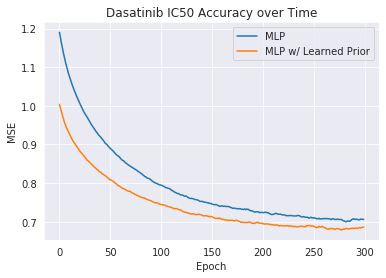

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("darkgrid")
plt.plot(mlp_errors, label="MLP")
plt.plot(prior_mlp_errors, label="MLP w/ Learned Prior")
plt.title("{} IC50 Accuracy over Time".format(drug_with_max_patients[5:]))
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [49]:
from data import BasicDataset

prior_data = BasicDataset(X = prior_info, y = np.zeros(prior_info.shape[0]))

meta_APExp = egexplainer.VariableBatchExplainer(prior_data)

In [50]:
for X_batch, y_batch in test_loader:
    y_batch = y_batch.squeeze()
    X_batch = X_batch.float().cuda()
    y_batch = y_batch.float().cuda()
    predicted_attributions = f2(prior_info).abs().squeeze().cpu().detach().numpy()
    meta_eg = meta_APExp.shap_values(f2, prior_info).abs().cpu().detach().numpy()

In [51]:
meta_eg = np.abs(meta_eg)
row_sums = meta_eg.sum(axis=1)
meta_eg = meta_eg / row_sums[:, np.newaxis]
meta_eg = (meta_eg.T * predicted_attributions).T
df = pd.DataFrame(data={
    "Mutation": meta_eg[:,0],
    "Hubness": meta_eg[:,1],
    "Regulator": meta_eg[:,2],
    "CNV": meta_eg[:,3],
    "Methylation": meta_eg[:,4],
    "total_attribution": predicted_attributions,
    "y":merge_data.data.columns
})

/homes/gws/ewein/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [58]:
num_bars = 25
data_to_plot = df.nlargest(num_bars, "total_attribution")

In [59]:
data_to_plot = data_to_plot.sort_values(by="total_attribution", ascending=True)
data_to_plot.drop("total_attribution", axis=1, inplace=True)
data_to_plot.set_index("y", inplace=True)

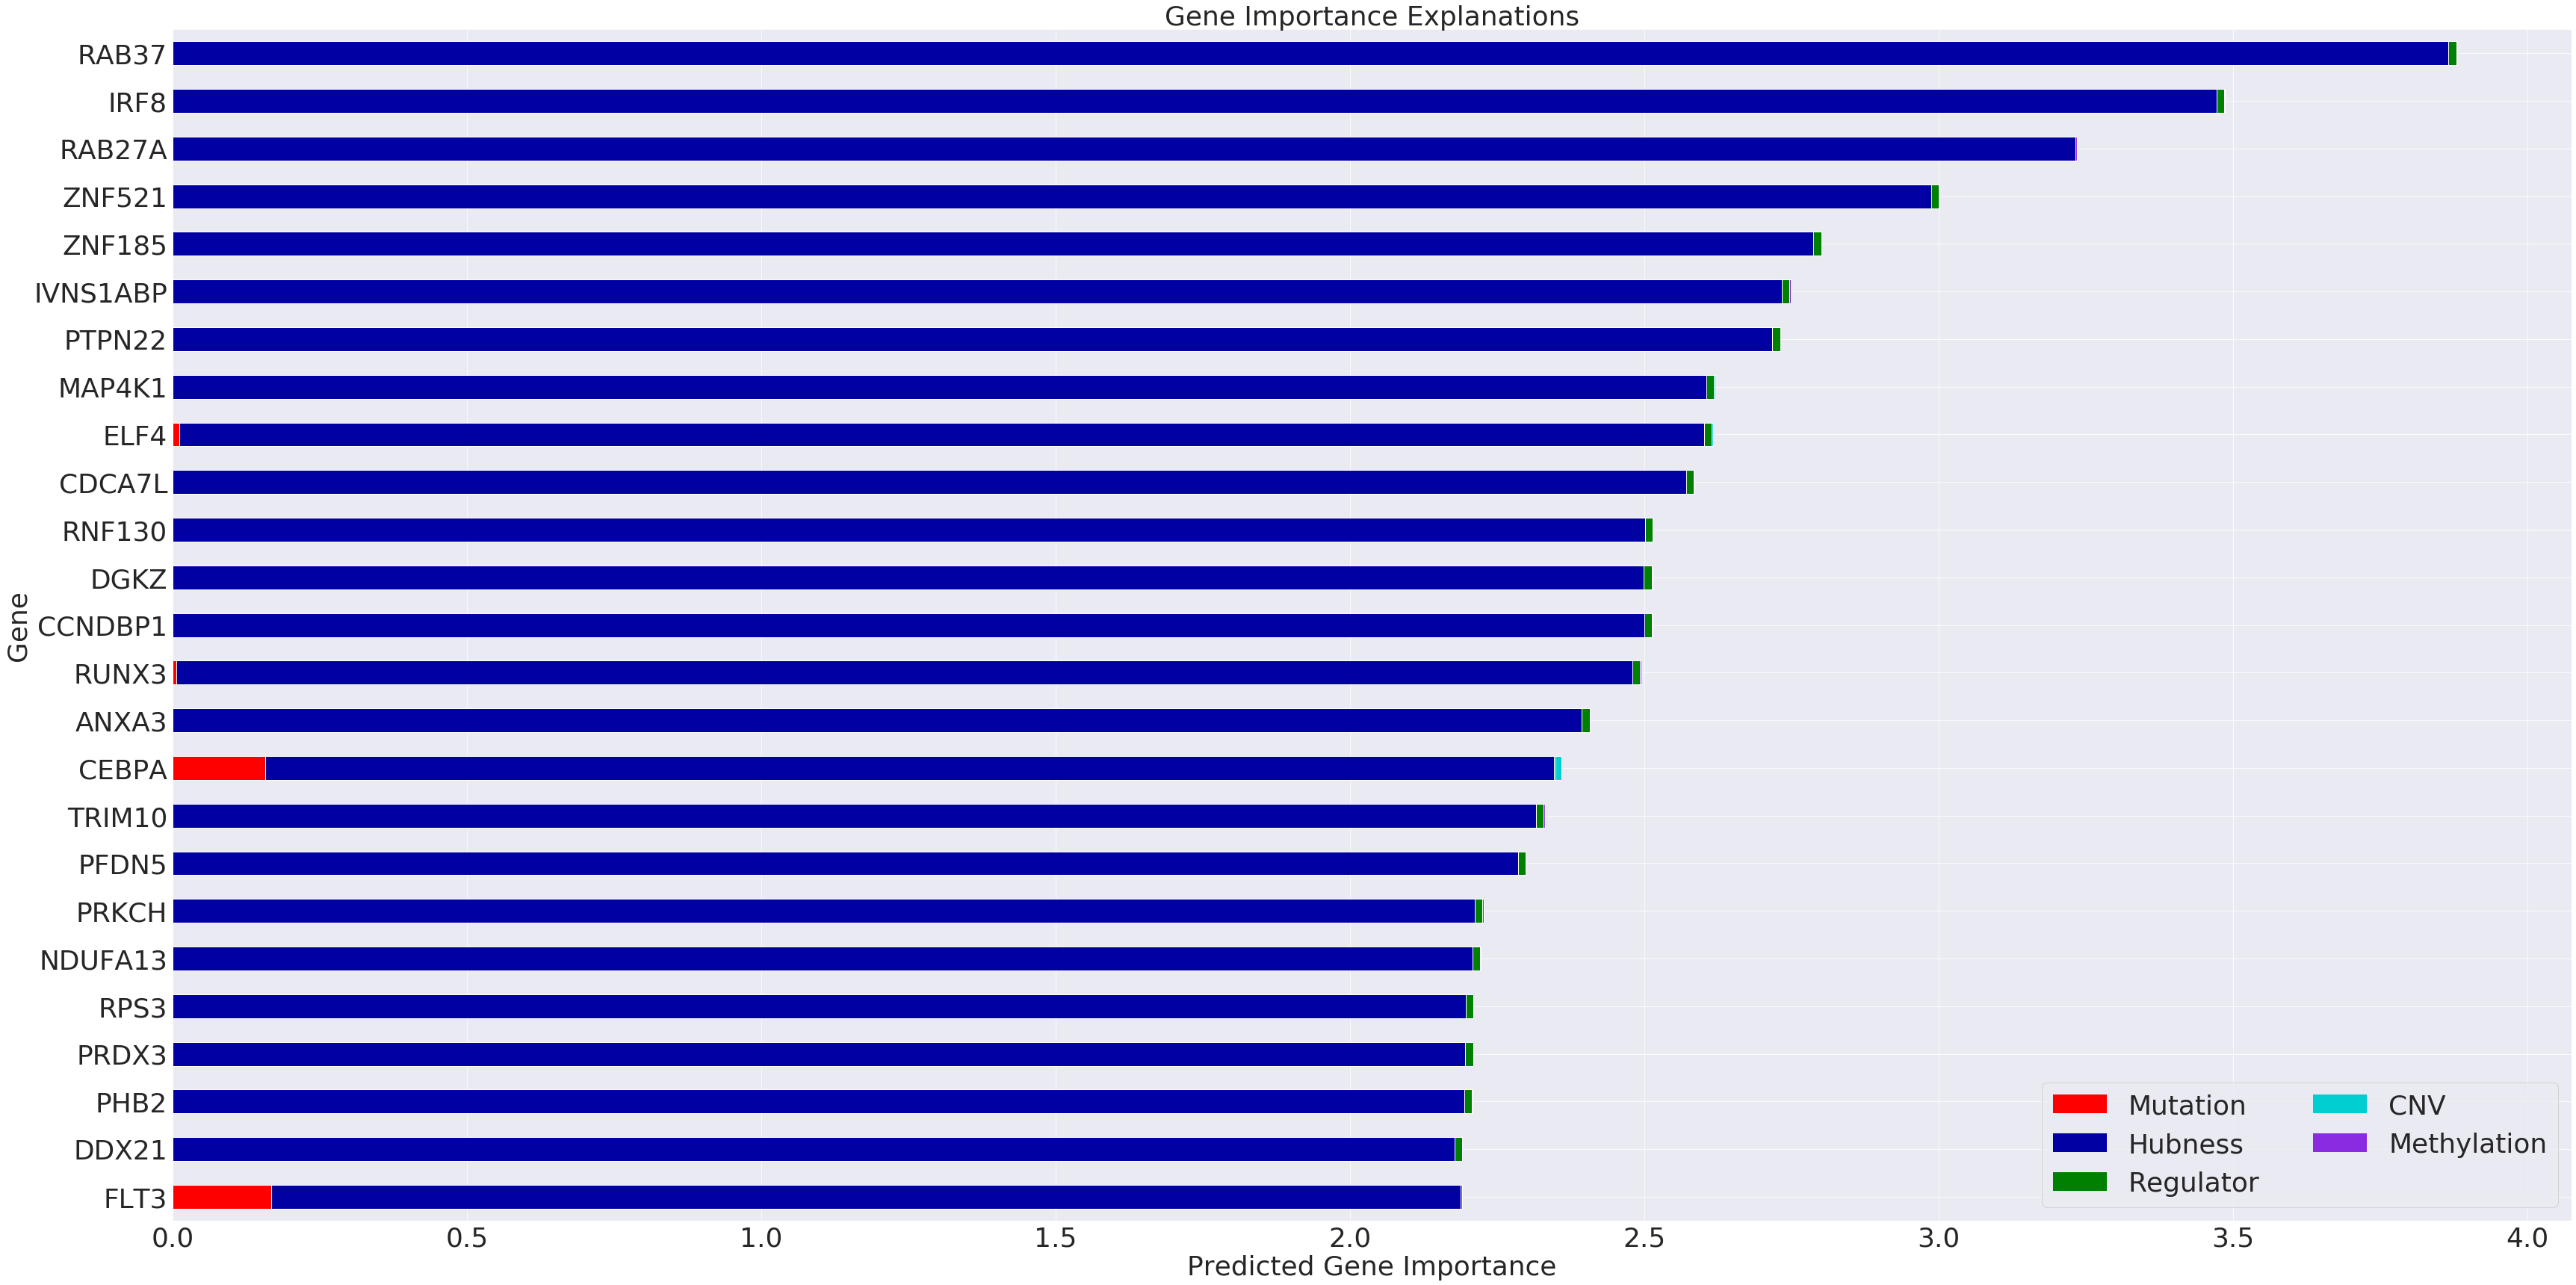

In [62]:
colors = {
    "mutation": "red",
    "hubness": "#0000A3",
    "regulator": "#008000",
    "cnv": "#00CED1",
    "methylation": "#8A2BE2"
}

mutation_bar = plt.Rectangle((0,0),1,1,fc=colors["mutation"], edgecolor = 'none')
hubness_bar = plt.Rectangle((0,0),1,1,fc=colors["hubness"],  edgecolor = 'none')
regulator_bar = plt.Rectangle((0,0),1,1,fc=colors["regulator"],  edgecolor = 'none')
cnv_bar = plt.Rectangle((0,0),1,1,fc=colors["cnv"], edgecolor = 'none')
methylation_bar = plt.Rectangle((0,0),1,1,fc=colors["methylation"],edgecolor = 'none')

data_to_plot.plot(
    kind="barh",
    stacked=True,
    color=[
        colors["mutation"],
        colors["hubness"],
        colors["regulator"],
        colors["cnv"],
        colors["methylation"]
    ],
    figsize=(48,24)
)

plt.xticks(fontsize=36)
plt.yticks(fontsize=36)

plt.legend(
    [mutation_bar, hubness_bar, regulator_bar, cnv_bar, methylation_bar],
    ['Mutation', 'Hubness', "Regulator", "CNV", "Methylation"],
    ncol = 2,
    prop={'size':36}
)

plt.title("Gene Importance Explanations", fontsize=36)
plt.ylabel("Gene", fontsize=36)
plt.xlabel("Predicted Gene Importance", fontsize=36)
plt.tight_layout()

In [81]:
from sklearn import linear_model

potential_alphas = np.linspace(start=0, stop=1, num=100)[1:]
best_mse = float("inf")

for alpha in potential_alphas:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(train_dataset.X, train_dataset.y)
    predictions = clf.predict(test_dataset.X)
    mse = ((predictions - test_dataset.y.values)**2).mean()
    if mse < best_mse:
        best_mse = mse
        print("Alpha, mse: {},{}".format(alpha, mse))

Alpha, mse: 0.010101010101010102,1.420016704333412
Alpha, mse: 0.020202020202020204,1.382702474834981
Alpha, mse: 0.04040404040404041,1.3814544341270274
Alpha, mse: 0.05050505050505051,1.317264194552284
Alpha, mse: 0.06060606060606061,1.2792184764700012
Alpha, mse: 0.07070707070707072,1.2480572249676587
Alpha, mse: 0.08080808080808081,1.229299745384961
Alpha, mse: 0.09090909090909091,1.2190712163668902
Alpha, mse: 0.10101010101010102,1.2118773271011913
Alpha, mse: 0.11111111111111112,1.20146784474707
Alpha, mse: 0.12121212121212122,1.1868819230531518
Alpha, mse: 0.13131313131313133,1.1725103085027506
Alpha, mse: 0.14141414141414144,1.1588587465015094
Alpha, mse: 0.15151515151515152,1.1472840499403854
Alpha, mse: 0.16161616161616163,1.1383274004223947
Alpha, mse: 0.17171717171717174,1.1306450448053658
Alpha, mse: 0.18181818181818182,1.1245450322662338
Alpha, mse: 0.19191919191919193,1.1200653588447684
Alpha, mse: 0.20202020202020204,1.1170534670948271
Alpha, mse: 0.21212121212121213,1.1

(0.6, 1.1481549986796915)

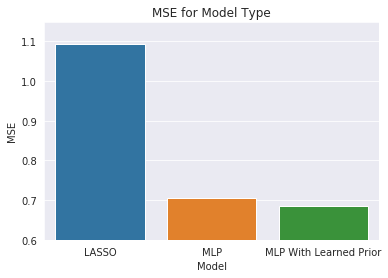

In [96]:
ax = sns.barplot(
    x = ["LASSO", "MLP", "MLP With Learned Prior"],
    y = [mse, mlp_errors[-1], prior_mlp_errors[-1]],
)
ax.set_title("MSE for Model Type")
ax.set_xlabel("Model")
ax.set_ylabel("MSE")
ax.set_ylim(0.6)